## 0. Import libraries

In [653]:
import torch
import pandas as pd
import numpy as np
import math, copy, time
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
from torch.optim import Adam
import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

## 1. Load Data

In [654]:
df = pd.read_csv('./total.csv')
df.tail()

,Date,S&P,currency,gold,kospi,kospi_shift
5334,2024-05-10,5222.680176,1365.400024,2367.300049,2727.629883,2727.209961
5335,2024-05-13,5221.419922,1370.109985,2336.100098,2727.209961,2730.340088
5336,2024-05-14,5246.680176,1363.790039,2353.399902,2730.340088,2753.000000
5337,2024-05-15,5308.149902,1362.550049,2388.699951,2730.340088,2753.000000
5338,2024-05-16,5308.149902,1362.550049,2387.100098,2753.000000,2753.000000


In [655]:
col_names = df.columns.values
print(col_names)

['Date' 'S&P' 'currency' 'gold' 'kospi' 'kospi_shift']


In [656]:
# global variables and hyperparameter
IN_DIM = 128
DAY_INT = 1
BATCH_SIZE = 64
SCALER = 'MINMAX'   # 'NORMAL'
# SCALER = 'NORMAL'   # 'NORMAL'
TRAIN_TEST_SPLIT = 0.95
LR = 1e-4

## 2. Split data train and test

In [657]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# print(df_train.tail())
# print(df_test.head())
scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
for i in col_names[1:]:
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

,S&P,currency,gold,kospi,kospi_shift
mean,2.058553e+03,1120.303866,1211.516482,1907.663422,1907.894126
var,1.037695e+06,11153.970584,197132.037659,285092.585746,285066.573366
max,4.796560e+03,1571.400024,2051.500000,3305.209961,3305.209961
min,6.765300e+02,886.679993,374.799988,719.590027,719.590027


In [658]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
if SCALER == 'MINMAX':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_names[1:]:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
test_data.tail()

,S&P,currency,gold,kospi,kospi_shift
5334,1.103426,0.699147,1.188346,0.776618,0.776456
5335,1.103121,0.706026,1.169738,0.776456,0.777667
5336,1.109252,0.696796,1.180056,0.777667,0.786430
5337,1.124171,0.694985,1.201109,0.777667,0.786430
5338,1.124171,0.694985,1.200155,0.786430,0.786430


In [659]:
class StockDataset(Dataset):
    def __init__(self, data, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        # print(data.shape)
        L = data.shape[0]
        features = data.shape[1] - 1
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        # print(data.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        X = np.zeros([num_samples, input_window, features])
        Y = np.zeros([num_samples, output_window])
        # print(X.shape, Y.shape)
        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[i, :, :] = data.iloc[start_x:end_x, :-1]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[i, :] = data.iloc[end_x: end_x + output_window, -1:]
        # print(X.shape, Y.shape)
        # X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        # Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        print(X.shape, Y.shape)
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [660]:
print(train_data.iloc[0:3, :])
train_dataset = StockDataset(train_data, 128, 1, 1)
# (5072, 5)

        S&P  currency      gold     kospi  kospi_shift
0  0.095531  0.455252  0.016640  0.033957     0.034108
1  0.094681  0.450286  0.017236  0.034108     0.034324
2  0.094223  0.446635  0.017356  0.034324     0.033083
(4944, 128, 4) (4944, 1)


### 3. create dataloader

In [661]:
train_dataset = StockDataset(train_data, 128, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data, 128, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
a1 = next(iter(train_dataset))
print(len(train_dataloader), len(train_dataloader.dataset), a1[0].shape, a1[1].shape)
print(a1)

(4944, 128, 4) (4944, 1)
(139, 128, 4) (139, 1)
78 4944 (128, 4) (1,)
(array([[0.09553085, 0.45525181, 0.01663984, 0.03395704],
       [0.09468134, 0.45028624, 0.01723625, 0.03410788],
       [0.0942226 , 0.44663511, 0.01735552, 0.03432446],
       [0.09543376, 0.44312999, 0.01699767, 0.03308297],
       [0.09343863, 0.43524352, 0.01884655, 0.02700317],
       [0.09533183, 0.43655796, 0.01896584, 0.02522024],
       [0.09311826, 0.43232262, 0.0199201 , 0.02620646],
       [0.09284399, 0.42312189, 0.01872728, 0.02902592],
       [0.0957954 , 0.41362896, 0.01777302, 0.0276684 ],
       [0.09650657, 0.41844834, 0.02063578, 0.03345039],
       [0.09502601, 0.42823346, 0.02051651, 0.03966938],
       [0.09674686, 0.42808746, 0.01962189, 0.03527199],
       [0.09707452, 0.43860263, 0.02218644, 0.03113373],
       [0.10015704, 0.43392926, 0.02123219, 0.03399957],
       [0.10003083, 0.44707332, 0.02051651, 0.03543057],
       [0.10106963, 0.45101646, 0.02135147, 0.03285477],
       [0.1018172

## 4. Make a Transformer model

In this sections, we will implement the building blocks of the transformer: [Positional encoding](#1a), [Multi-head attention](#1b) and [Position wise feedforward network](#1c)

### a. Sinusoidal Positional Encoding
<a id='1a'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [662]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model , max_len, device):
        """
        d_model: dimension of model
        max_len: maximum sequence length
        device: 'cuda' or 'cpu'
        """
        super().__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.required_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1) # [a, b, ...] -> [[a], [b], [c], ...]

        _2i = torch.arange(0, d_model, step=2, device=device) # i is d_model and step=2 means 2*i
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
    
    def forward(self, x):
        # x: Tensor, shape ``[batch_size, seq_len, embedding_dim]
        # d_model = 512
        # print(x.size())
        batch_size, seq_len = x.size()[:2]
        pe = self.encoding[:seq_len, :]
        return pe

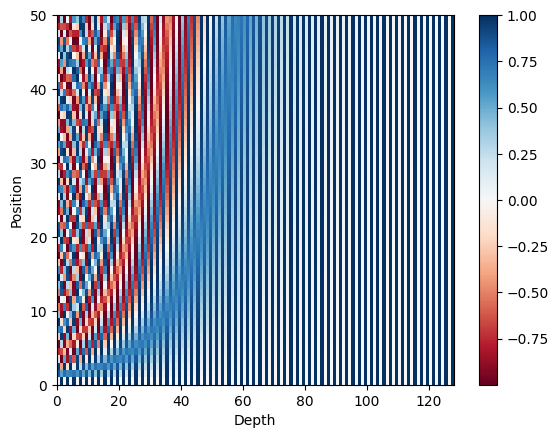

In [663]:
sample_pos_encoding = PositionalEncoding(128, 50, device='cpu')

plt.pcolormesh(sample_pos_encoding.encoding.numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()


### b. Scaled dot product attention

__Scaled dot product:__
![picture](./assets/transformer_2.png)

In [664]:
class ScaleDotProductAttention(nn.Module):
    """
    Query: given setence
    Key: same with query(encoder)
    Value: same with key
    """

    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None, e=1e-12):
        # input: 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. q @ K.T
        k_t = k.transpose(2, 3)
        score = (q @ k_t) / math.sqrt(d_tensor)

        # 2. masking(decoder self attention only)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)
        
        # 3. pass them softmax to [0, 1] range
        score = self.softmax(score)

        # 4. multiply with value
        v = score @ v

        return v, score

### c. MultiheadAttention
<a id='1b'></a>
Equation:

$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$

In [665]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. scale dot product
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out
    
    def split(self, tensor):
        '''
        split tensor by heads
        tensor: [batch_size, seq_len, d_model]
        return: [batch_size, head, seq_len, d_tensor] --- d_model = head * d_tensor
        '''
        batch_size, seq_len, d_model = tensor.size()
        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, seq_len, self.n_head, d_tensor).transpose(1, 2)
        # split by # of heads
        return tensor
    
    def concat(self, tensor):
        '''
        inverse of split(tensor)
        tensor: [batch_size, head, seq_len, d_tensor]
        return: [batch_size, seq_len, d_model]
        '''
        batch_size, head, seq_len, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        return tensor
        

### d. Position-wise feed forward network
<a id='1c'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [666]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

### e. Layer Normalization

In [667]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True)
        # -1 to get mean and var for the last dimension(d_model)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

## 5. Embedding input data

make 1 input dimension data to d_model dimentions

In [668]:
class LinearEmbedding(nn.Module):
    def __init__(self, dropout, d_model):
        '''
        data: [batch_size, seq_len, 1]
        In this model, only kospi input window
        '''
        super().__init__()
        self.d_model = d_model
        self.linear1 = nn.Linear(1, d_model//2)
        self.linear2 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        # self.normal = LayerNorm(d_model=d_model)
    
    def forward(self, x):
        '''
        input: [batch_size, seq_len, 4]
        output: [batch_size, seq_len, 4, d_model]
        '''
        batch_size, sel_len, x_len = x.size()
        x = x.unsqueeze(-1)
        cls_token = torch.rand((x.size()[0], x.size()[1], 1, x.size()[-1]), device=x.device)
        # print(cls_token.size(), x.size())
        # print(x[0, 0, :, :])
        x = torch.concat([x, cls_token], dim=2) # add CLS token for attention. pos [ , , , -1]
        # print(x.size())
        # print(x[0, 0, :, :])
        residual = x
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # x = self.normal(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x


In [669]:
class EmbeddingAttention(nn.Module):
    def __init__(self, model_d):
        super().__init__()
        self.w_q = nn.Linear(model_d, model_d)
        self.w_k = nn.Linear(model_d, model_d)
        self.w_v = nn.Linear(model_d, model_d)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None, e=1e-12):
        # q: 4 dimension tensor
        # [batch_size, seq_len, length, model_d] q length is 1 and k, v length is 4
        batch_size, seq_len, length, model_d = k.size()
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 1. q @ K.T
        k_t = k.transpose(2, 3)
        # print('q_size:', q.size(), ' , k_t_size:', k_t.size())
        score = (q @ k_t) / math.sqrt(model_d)

        # 2. masking(decoder self attention only)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)
        
        # 3. pass them softmax to [0, 1] range
        score = self.softmax(score)

        # 4. multiply with value
        v = score @ v

        return v, score

In [670]:
class TrnasformerEmbedding(nn.Module):
    '''
    d_model: dimension of input data
    seq_len: max length of sequence
    '''
    def __init__(self, dropout, d_model, seq_len, device):
        super().__init__()
        self.lin_emb = LinearEmbedding(dropout, d_model)
        self.emb_attn = EmbeddingAttention(d_model)
        self.pos_emb = PositionalEncoding(d_model, seq_len, device)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        lin_emb = self.lin_emb(x)
        attn_emb, score = self.emb_attn(lin_emb[:, :, -1, :].unsqueeze(2), lin_emb[:, :, :-1, :], lin_emb[:, :, :-1, :])
        attn_emb = attn_emb.squeeze(2)
        pos_emb = self.pos_emb(x)
        # print('attn_emb:', attn_emb.size())
        # print('pos_emb:', pos_emb.size())
        return self.dropout(attn_emb + pos_emb)

## 6. Encoder Layer
Trnasformer Encoder Except Embedding

In [671]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, n_head, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.normal1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=dropout)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, dropout=dropout)
        self.normal2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=dropout)
    
    def forward(self, x, src_mask=None):
        # 1. multihead Attention
        residual = x
        x = self.attention(x, x, x)

        # 2. add and norm
        x = self.dropout1(x)
        x = self.normal1(x + residual)

        # 3. positionwise FFN
        residual = x
        x = self.ffn(x)

        # 4. add and norm
        x = self.dropout2(x)
        x = self.normal2(x + residual)

        return x

## 7. Encoder
Build Embedding and Encoder Block

In [672]:
class Encoder(nn.Module):
    def __init__(self, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        super().__init__()
        self.emb = TrnasformerEmbedding(dropout, d_model, seq_len, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, ffn_hidden, n_head, dropout)
                                     for _ in range(n_layers)])
    
    def forward(self, x):
        x = self.emb(x)
        for layer in self.layers:
            x = layer(x)
        
        return x

## 8. Transformer Encoder
Only use encoder module and FFN 

In [673]:
class TransformerEncoder(nn.Module):
    def __init__(self, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        super().__init__()
        self.encoder = Encoder(seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        # self.flatten = nn.Flatten()
        # self.flatten_dim = seq_len * d_model
        self.linear1 = nn.Linear(d_model, d_model // 2)
        self.linear2 = nn.Linear(d_model // 2, d_model // 4)
        self.linear3 = nn.Linear(d_model // 4, 1)
        # self.linear1 = nn.Linear(self.flatten_dim, self.flatten_dim // 10)
        # self.linear2 = nn.Linear(self.flatten_dim // 10, self.flatten_dim//100)
        # self.linear3 = nn.Linear(self.flatten_dim//100, 1)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.encoder(x)[:, -1, :]
        # x = self.flatten(x)
        # print(x.size())
        # x = self.linear1(x)[:, -1, :]
        x = self.linear1(x)
        # print(x.size())
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.relu(x)
        return x

## 9. model, loss_fn, optimizer


In [674]:
# next(iter(train_dataloader)).shape
# torch.cuda.empty.cache()
batch_size, seq_len, input_dim = next(iter(train_dataloader))[0].size()
print(batch_size, seq_len, input_dim)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_d = 1024
dropout = 0.2
ffn_hidden = model_d // 2
n_layers = 4
n_head = 8
lr_sched = True

64 128 4


In [675]:
model = TransformerEncoder(seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 1e-4)
if lr_sched == True:
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                     lr_lambda=lambda epoch: 0.95 ** epoch,
    #                                     last_epoch=-1,
    #                                     verbose=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)

In [676]:
model

TransformerEncoder(
  (encoder): Encoder(
    (emb): TrnasformerEmbedding(
      (lin_emb): LinearEmbedding(
        (linear1): Linear(in_features=1, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=1024, bias=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (emb_attn): EmbeddingAttention(
        (w_q): Linear(in_features=1024, out_features=1024, bias=True)
        (w_k): Linear(in_features=1024, out_features=1024, bias=True)
        (w_v): Linear(in_features=1024, out_features=1024, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (pos_emb): PositionalEncoding()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=1024, out_features=1024, bias=True)
          (w_k):

## 10. Train and Test function

In [677]:
linear_model = LinearEmbedding(0.2, model_d).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = linear_model(in_x)
out.size()
print(in_x.size())
print(out.size())

torch.Size([64, 128, 4])
torch.Size([64, 128, 5, 1024])


In [678]:
a = torch.rand((64, 128, 1, 1024))
b = torch.rand((64, 128, 1024, 4))
c = a @ b
print(a[:, :, -1, :].unsqueeze(2).size())
c.size()

torch.Size([64, 128, 1, 1024])


torch.Size([64, 128, 1, 4])

In [679]:
emb_model = TrnasformerEmbedding(0.2, model_d, seq_len, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = emb_model(in_x)
out.size()

torch.Size([64, 128, 1024])

In [680]:
encoder_model = Encoder(seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = encoder_model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 128, 1024])
torch.Size([64, 1])
torch.Size([64])


In [681]:
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([64])


In [682]:
epochs = 10
loss_np = np.zeros((epochs, 2))
df_loss = pd.DataFrame(loss_np, columns=['epoch', 'loss'])
for i in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        # print(inputs.size(), labels.size())

        optimizer.zero_grad()
        output = model(inputs)
        # print(output.size())
        loss = loss_fn(output.float(), labels.float())
        # print(loss)
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)  # when using scheduler, it is not for grad exploding
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f'epochs: {i}, loss: {epoch_loss:.6f}, lr: ', round(optimizer.param_groups[0]['lr'], 8))
    if lr_sched == True:
        scheduler.step()
    df_loss.loc[i, :] = [i, epoch_loss]

In [ ]:
save_path = 'transormer_kospi_w_other_window_model_d' + str(model_d) +'seqlen' + str(seq_len) + '_layaers' + str(n_layers) + '_nhead' + str(n_head) + '.pt'
# save_path = 'kospi_only.pt'
torch.save(model.state_dict(), save_path)
print(save_path)
df_loss

transormer_kospi_only_window_seqlen128_layaers4_nhead8.pt


,epoch,loss
0,0.0,1.592326
1,1.0,0.365356
2,2.0,0.298722
3,3.0,0.257962
4,4.0,0.230753
...,...,...
995,995.0,0.035347
996,996.0,0.035542
997,997.0,0.036681
998,998.0,0.035470


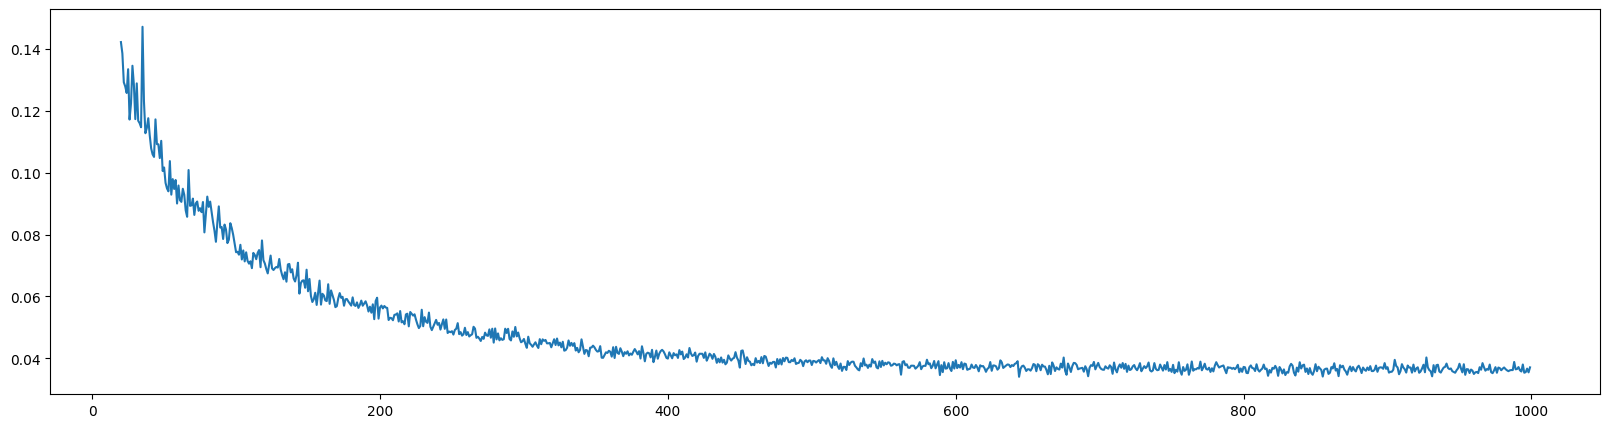

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_loss.loc[20: , 'epoch'], df_loss.loc[20: , 'loss'])
plt.show()

In [ ]:
test_result = pd.DataFrame(columns=['pred', 'pred_rescale', 'real'])
num = 0
min = scale_params.loc['min', 'kospi']
max = scale_params.loc['max', 'kospi']
with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1]

        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            pred_scaled = pred_ * (max - min) + min
            out_scaled = outputs.numpy()[i] * (max - min) + min
            test_result.loc[num] = [pred_, pred_scaled, out_scaled[0][0]]
            num += 1

In [ ]:
test_result

,pred,pred_rescale,real
0,0.627339,2341.650111,2302.810059
1,0.631707,2352.943809,2310.550049
2,0.595763,2260.006479,2277.989990
3,0.580362,2220.186719,2301.560059
4,0.578057,2214.225090,2343.120117
...,...,...,...
134,0.814766,2826.265828,2683.649902
135,0.728907,2604.265389,2676.629883
136,0.768147,2705.726663,2676.629883
137,0.773429,2719.383098,2734.360107


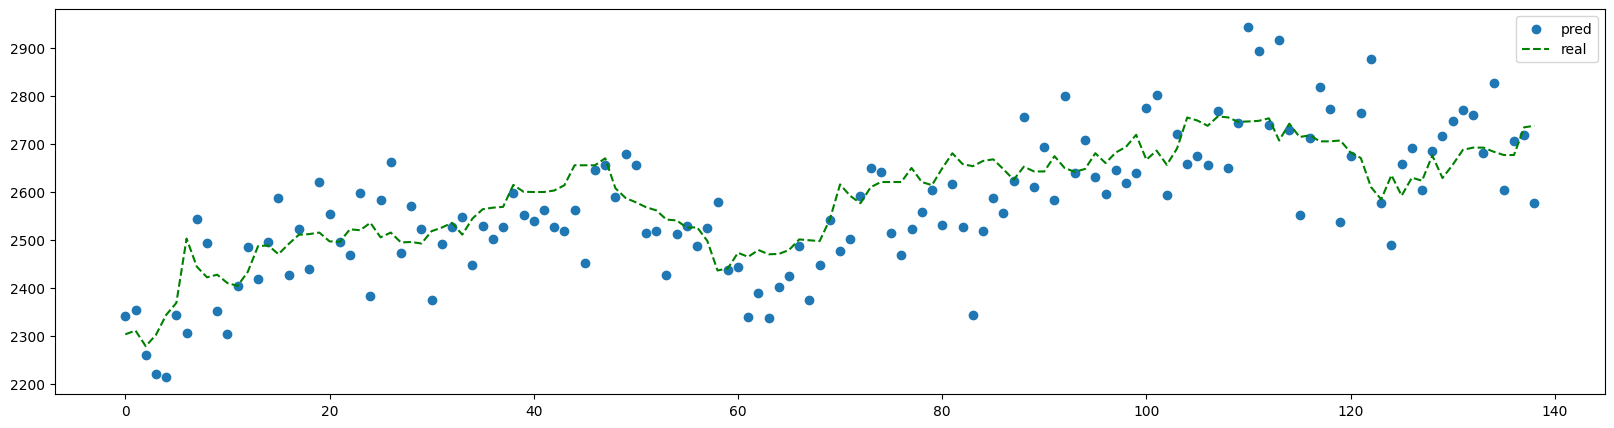

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

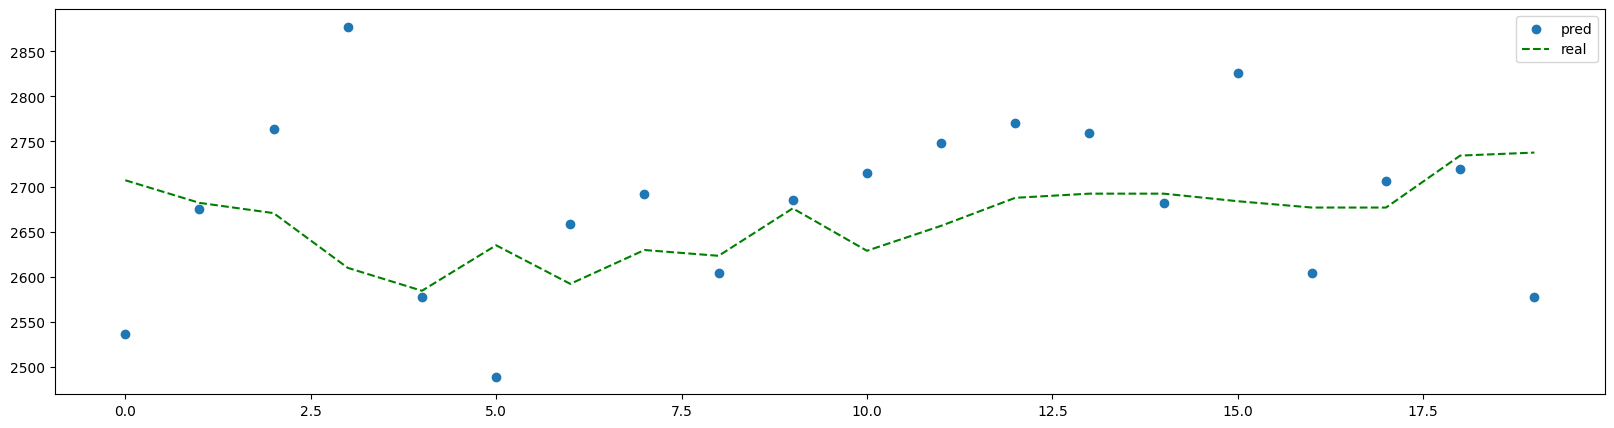

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 1], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

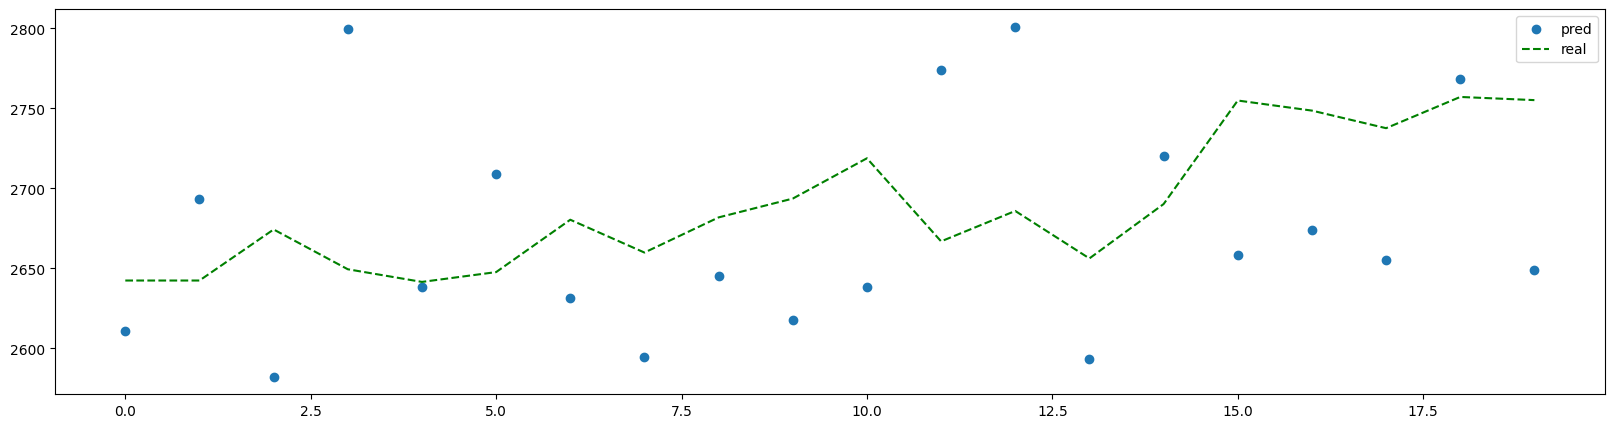

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 1], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 2], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

In [ ]:
df_ma = test_result.copy()
df_ma['sma_pred_5d'] = df_ma['pred_rescale'].rolling(5).mean()
df_ma['sma_pred_10d'] = df_ma['pred_rescale'].rolling(10).mean()
df_ma['sma_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['sma_real_5d'] = df_ma['real'].rolling(5).mean()
df_ma['sma_real_10d'] = df_ma['real'].rolling(10).mean()
df_ma['sma_real_20d'] = df_ma['real'].rolling(20).mean()
df_ma['ewm_pred_5d'] = df_ma['pred_rescale'].ewm(5).mean()
df_ma['ewm_pred_10d'] = df_ma['pred_rescale'].ewm(10).mean()
df_ma['ewm_pred_20d'] = df_ma['pred_rescale'].ewm(20).mean()
df_ma['ewm_real_5d'] = df_ma['real'].ewm(5).mean()
df_ma['ewm_real_10d'] = df_ma['real'].ewm(10).mean()
df_ma['ewm_real_20d'] = df_ma['real'].ewm(20).mean()
df_ma = df_ma.dropna()
df_ma

,pred,pred_rescale,real,sma_pred_5d,sma_pred_10d,sma_pred_20d,sma_real_5d,sma_real_10d,sma_real_20d,ewm_pred_5d,ewm_pred_10d,ewm_pred_20d,ewm_real_5d,ewm_real_10d,ewm_real_20d
19,0.735303,2620.803773,2514.959961,2519.307115,2470.060312,2429.327021,2499.625977,2471.964966,2420.952515,2480.409957,2449.792775,2429.327021,2476.336905,2454.753425,2439.329139
20,0.709639,2554.445571,2496.629883,2512.885822,2495.219501,2438.621078,2504.981934,2480.661963,2430.643506,2493.023401,2460.793153,2438.621078,2479.794218,2459.155189,2443.585553
21,0.686607,2494.895706,2495.659912,2526.369371,2504.381374,2442.692708,2505.873926,2489.851953,2439.898999,2493.341208,2464.327575,2442.692708,2482.487283,2462.938573,2447.353282
22,0.676558,2468.913157,2521.760010,2515.637699,2502.750637,2444.544042,2508.141943,2498.702954,2452.087500,2489.207468,2464.796854,2444.544042,2489.133055,2468.958242,2452.606881
23,0.726533,2598.129148,2519.810059,2547.437471,2520.778912,2455.144472,2509.763965,2502.016968,2463.000000,2507.592347,2478.287631,2455.144472,2494.311023,2474.103511,2457.245238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0.814766,2826.265828,2683.649902,2757.021700,2713.881887,2691.907744,2682.308008,2656.023022,2664.506482,2726.510341,2713.423254,2691.907744,2669.036319,2670.831449,2669.217028
135,0.728907,2604.265389,2676.629883,2728.297754,2708.455346,2687.728811,2686.367969,2664.500000,2662.627478,2706.136183,2703.499788,2687.728811,2670.301913,2671.358581,2669.570485
136,0.768147,2705.726663,2676.629883,2715.395065,2709.907494,2688.586925,2684.205957,2669.218994,2660.576477,2706.067929,2703.702232,2688.586925,2671.356574,2671.837791,2669.907068
137,0.773429,2719.383098,2734.360107,2707.417181,2721.477459,2690.055158,2692.665967,2680.353003,2662.036487,2708.287124,2705.127768,2690.055158,2681.857163,2677.521649,2672.979920


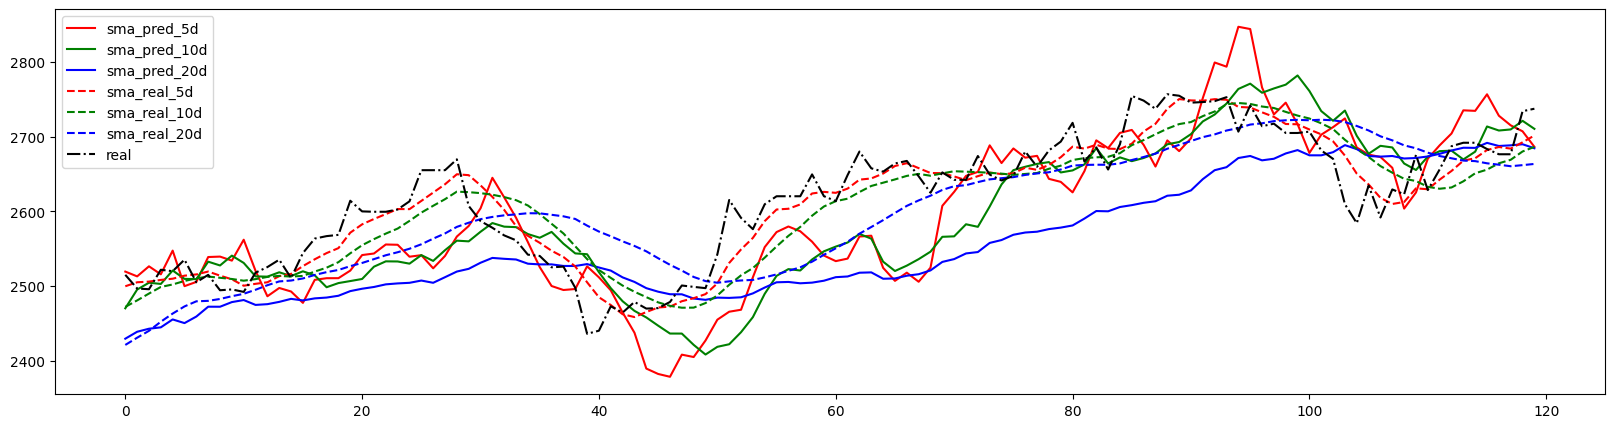

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

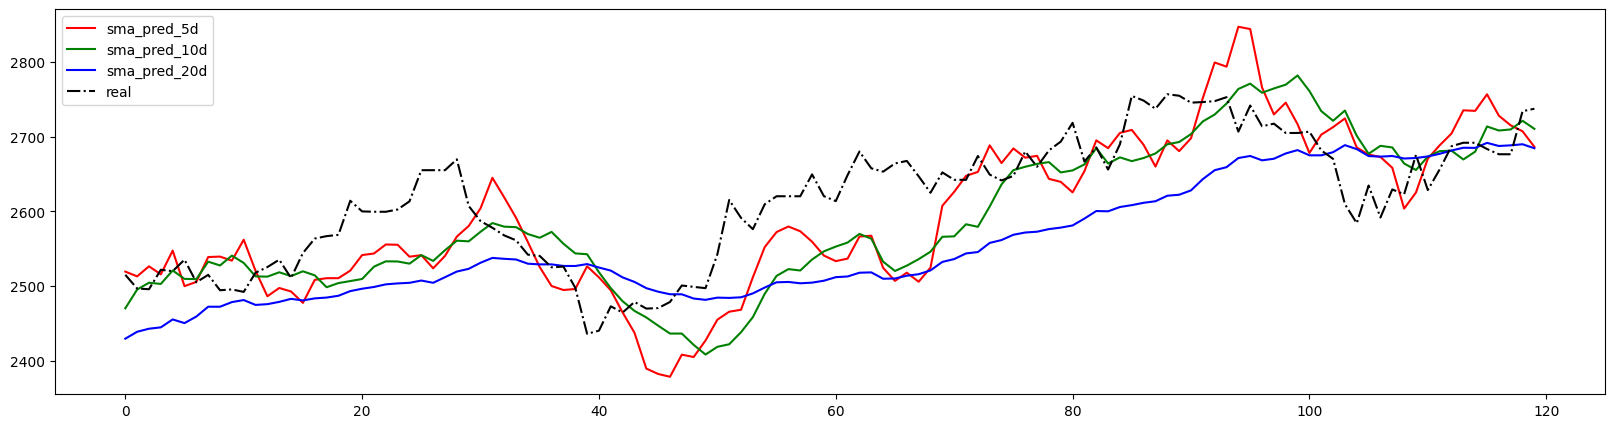

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['sma_pred_5d'], 'r-', label='sma_pred_5d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_10d'], 'g-', label='sma_pred_10d')
plt.plot(range(len(df_ma)), df_ma['sma_pred_20d'], 'b-', label='sma_pred_20d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_5d'], 'r--', label='sma_real_5d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_10d'], 'g--', label='sma_real_10d')
# plt.plot(range(len(df_ma)), df_ma['sma_real_20d'], 'b--', label='sma_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

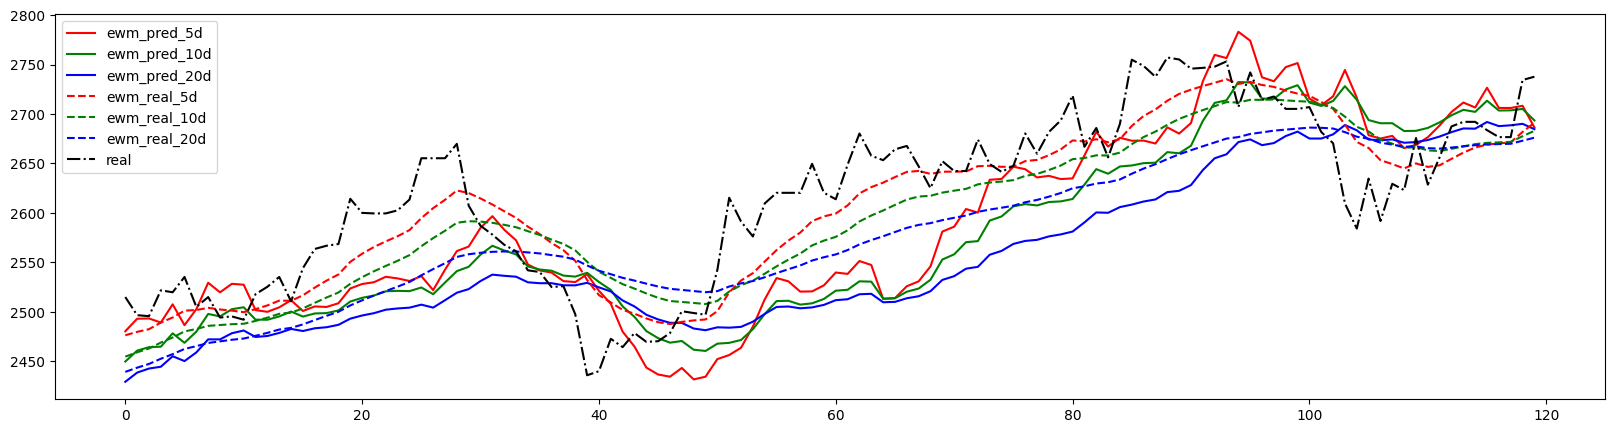

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(df_ma)), df_ma['ewm_pred_5d'], 'r-', label='ewm_pred_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_10d'], 'g-', label='ewm_pred_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_pred_20d'], 'b-', label='ewm_pred_20d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_5d'], 'r--', label='ewm_real_5d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_10d'], 'g--', label='ewm_real_10d')
plt.plot(range(len(df_ma)), df_ma['ewm_real_20d'], 'b--', label='ewm_real_20d')
plt.plot(range(len(df_ma)), df_ma['real'], 'k-.', label='real')
plt.legend()
plt.show()

## 11. evaluation metrics
MAPE, MSE

In [ ]:
mse = mean_squared_error(test_result['real'], test_result['pred_rescale'])
mape = mean_absolute_percentage_error(test_result['real'], test_result['pred_rescale'])
print(f'MSE: {mse:.4f}, MAPE: {mape:.4f}')

MSE: 8639.9525, MAPE: 0.0285
